# Terrain Classification - General Data
### Created by Keenan McConkey 2019.8.12

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used for classification
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']

'''Get columns for given label'''
def get_columns(label):
    # Columns differ for synthesis data
    if 'Middle' in label or 'Left' in label or 'Right' in label:
        columns = std_columns.copy()
    elif 'Synthesis' in label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in label or 'PSD' in label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Middle']
transforms = ['FFT', 'PSDLog', 'PSD']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
glob_paths = glob.glob('imu_data/new_setup/set_power/*.csv')

# Remove 9250 IMU data (for now)
dataset_paths = [path for path in glob_paths if '9250' not in path]

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
    
    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to easier to work with names
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in sec
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle frame data
    ## Can't remove from wheel-mounted Left and Right wheel data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns to put Run Time and Epoch Time at the end
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Use different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use as the time domain
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time']

In [7]:
# Sort dictionary according to keys
raw_datasets = {label: raw_datasets[label] for label in sorted(raw_datasets.keys())}

# Save list of keys to variable
dataset_labels = list(raw_datasets.keys())
print('Number of raw datasets: {}'.format(len(dataset_labels)))

Number of raw datasets: 86


In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
3580,-23.988916,-5.102570,9.122623,-0.197604,-0.243000,0.060402,11.963924,1.564169e+09
3581,20.311558,1.358465,-3.512076,-0.804154,-0.465428,0.534028,11.967745,1.564169e+09
3582,-5.398475,7.029232,-4.707057,1.160674,0.377935,-0.434001,11.970022,1.564169e+09
3583,7.490068,-8.366613,4.460045,-0.845976,-0.351417,0.435200,11.973553,1.564169e+09
3584,9.310078,-3.378350,-2.372176,-0.505807,-0.143906,0.150172,11.976680,1.564169e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single Pandas dataset for given x and y axes'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    # Figure parameters
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    # Add relevant units to y label
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    # Use limits if they've been passed in
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Plot relevant data
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

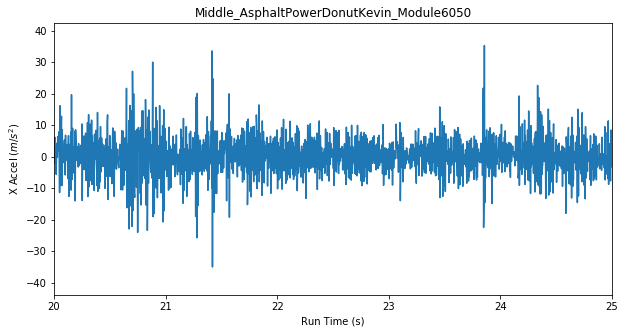

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas datasets by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, y_axis, t_offset=0, y_offset=0):
    # Plot parameters
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_title(y_axis + ' for ' + label1 + ' and ' + label2)
        
    # Add relevant units to y label
    if 'Gyro' in y_axis:
        ax.set_ylabel(y_axis + ' ($rad/s$)')
    elif 'Accel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s^2$)')
    elif 'Vel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s$)')
    else:
        ax.set_ylabel('Unknown')
    
    # Plot data with given y and t offsets applied to first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][y_axis], label=label2)
    
    # Include offset info text in plot
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraightKevin_Module',
#                raw_datasets, 'Right_ConcreteStraightKevin_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    # Set paramaeters based on number of datasets to plot
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 0
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
    axes = []
    row, col = 0, 0
    
    # Plot each of the given datasets
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

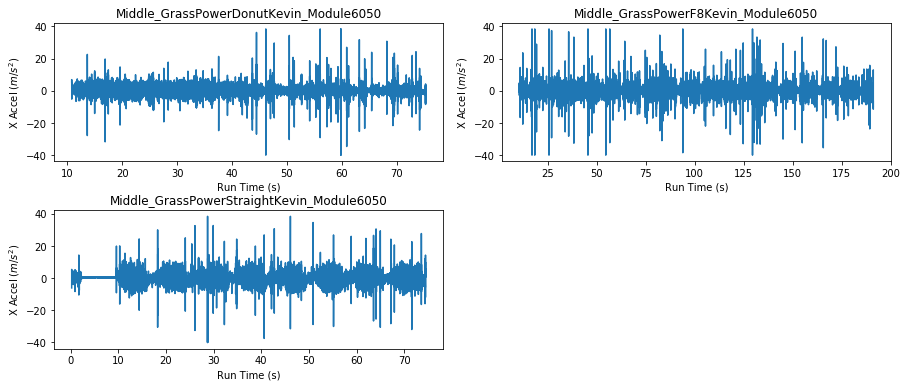

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Middle' in label and 'Grass' in label and 'Kevin' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='X Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D NumPy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D NumPy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))     
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 86
Shape of first dataset: (18301, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    # Sampling frequency differs varies between frame and wheel modules
    # Synthesis data is created from combining left and right wheel data so it has the same samp rate
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label')
        
    return window_size

In [23]:
'''Get number of data columns in dataset with given label'''
def get_n_data_col(label):
    # Different number of columns for Synthesis datasets
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

# Filter each dataset individually
for label, raw_dataset in raw_datasets.items():
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])
        
    datasets.update({label: dataset})

In [25]:
# Check construction of filtered dataset
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 86
Shape of first filtered dataset: (18301, 8)


In [26]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-23.988526,-5.102349,9.122516,-0.197619,-0.243012,0.060412,11.963924,1.564169e+09
1,-3.263027,-0.788822,1.458658,-0.043053,-0.143328,0.081821,11.967745,1.564169e+09
2,8.904048,0.783666,-2.562237,-0.045971,-0.093451,0.114073,11.970022,1.564169e+09
3,10.330600,-0.234367,-2.419928,-0.189873,-0.093614,0.152100,11.973553,1.564169e+09
4,5.166488,-1.550808,-0.385772,-0.305261,-0.099362,0.170821,11.976680,1.564169e+09


<Figure size 432x288 with 0 Axes>

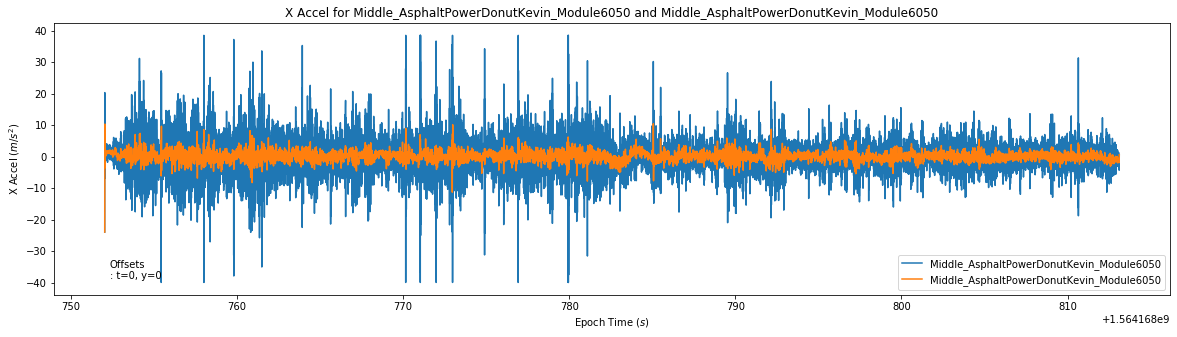

In [27]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [28]:
'''Compare Z Gyro of frame to Z Gyro calculated by combining wheel data, for Pandas data'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro using wheel data
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [29]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [30]:
datasets_windowed = {}
# TODO: Create dictionary of different window sizes for comparing
# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Total windows that fit in the dataset
    n_points = n_windows * window_size # Total number of points that fit in non-overlapping windows
    
    # Windowed data
    dataset_windowed = []
    
    # Iterate through dataset by half a window at a time and extract windows
    i = 0
    window_slide = int(window_size / 2)
    
    while (i < n_points):
        dataset_windowed.append(dataset[i:i + window_size])
        i += window_slide
    
    datasets_windowed.update({label: dataset_windowed})

In [31]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 86
Num of windows in first dataset: 122
Shape of individual window: (300, 8)


In [32]:
# Try out Pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,1.455985,0.618996,-0.786505,-0.000542,-0.045552,0.728028,12.946578,1.564169e+09
296,1.615853,0.906019,-1.326529,0.010571,0.004249,0.745552,12.949646,1.564169e+09
297,1.873769,0.815062,-1.147583,0.035787,0.062342,0.747614,12.953425,1.564169e+09
298,1.587195,0.315954,-0.111281,0.038605,0.069477,0.741679,12.956563,1.564169e+09
299,0.566938,-0.058097,1.174393,0.018347,-0.003193,0.739190,12.959626,1.564169e+09


<Figure size 432x288 with 0 Axes>

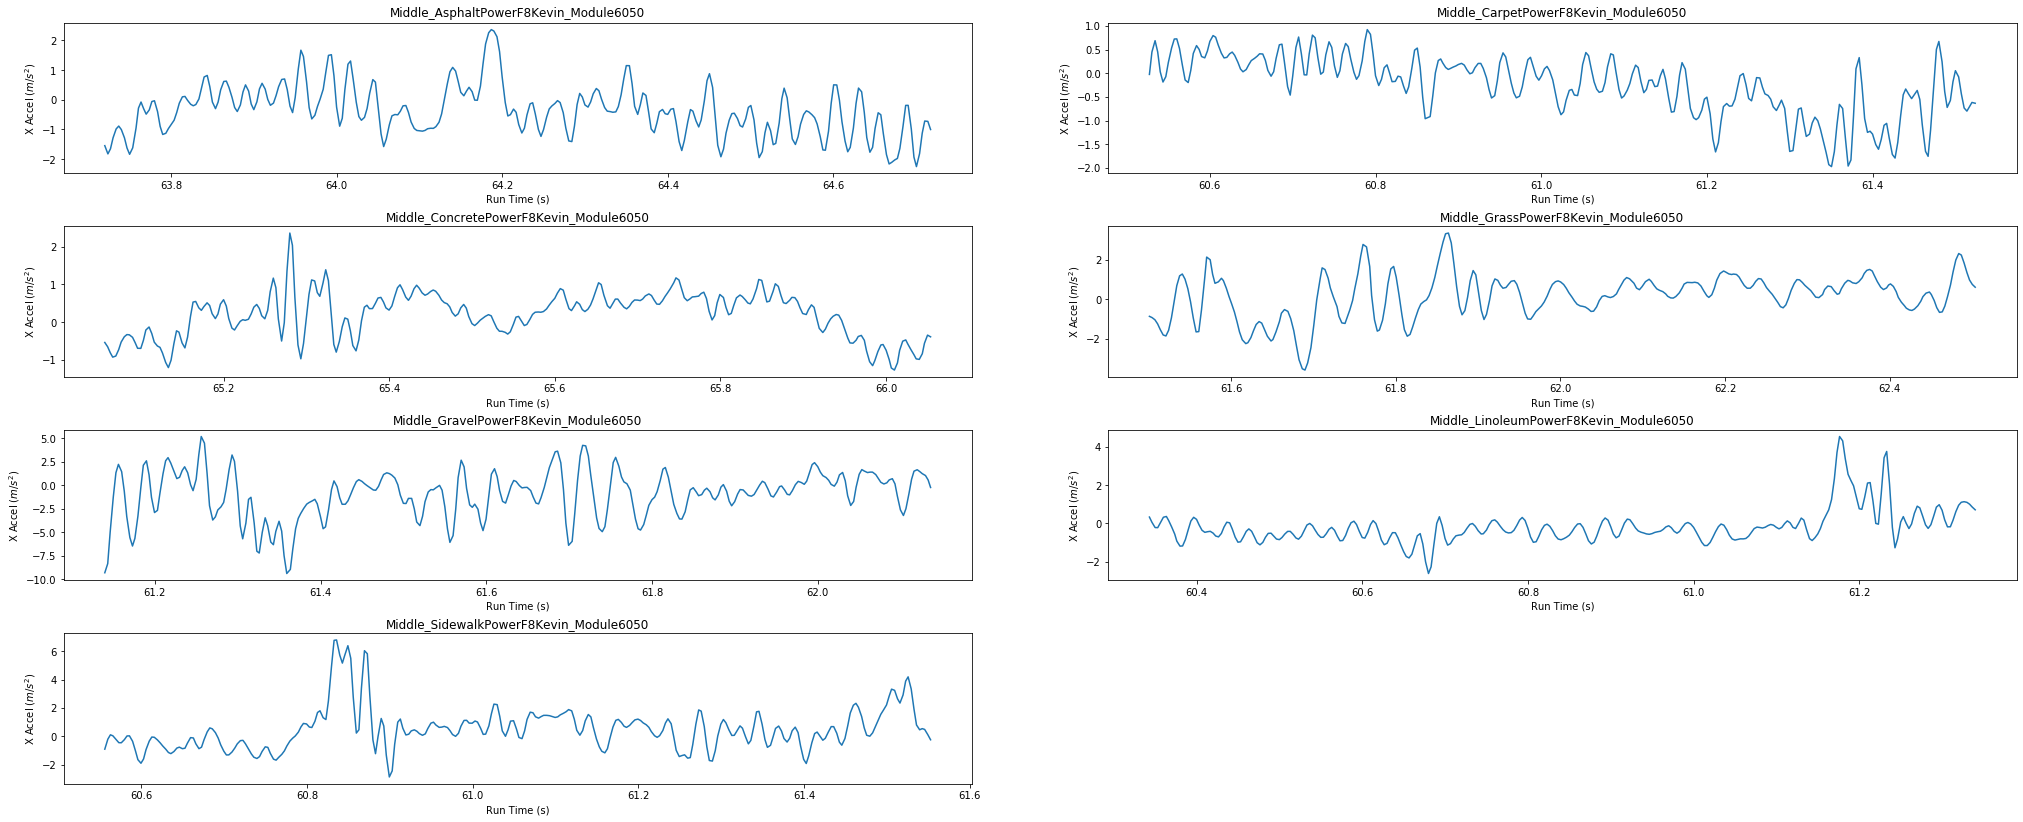

In [33]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='X Accel', windowed=True, win_num=102)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [34]:
# Butterworth filter bandpass isn't a perfect edge so there is still some relevant data past the cutoff
N_BINS_OVER_CUTOFF = 5

In [35]:
'''Plot transform of given direction and window of a windowed NumPy dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    plt.show()

### Part (a) - FFT

In [36]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Get relevant parameters for given label
        f_samp, f_low, f_high = get_frequencies(label)        
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            # TODO: Look into complex output of fft function
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + '_FFT': dataset_fft})

In [37]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'_FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'_FFT'][0].shape))

# Test Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'_FFT'][0].head()

Num of FFT'd windowed datasets: 86
Num of FFT'd windows in first dataset: 118
Shape of FFT'd individual window: (60, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.862495,0.404910,0.041393,0.012373,0.013310,0.483653,0.0
1,0.318967,0.230124,0.015110,0.007814,0.006220,0.159129,1.0
2,0.215261,0.137851,0.045961,0.007200,0.003914,0.053439,2.0
3,0.131843,0.023547,0.018354,0.000642,0.003640,0.025592,3.0
4,0.083893,0.077199,0.036534,0.005916,0.004910,0.025552,4.0


<Figure size 432x288 with 0 Axes>

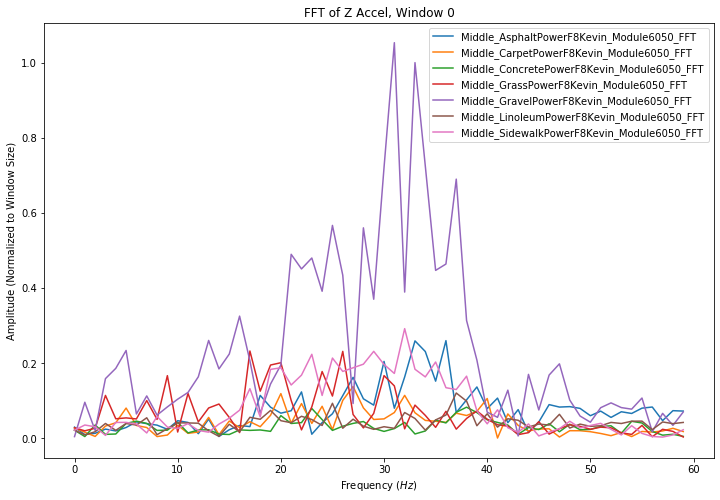

In [38]:
# Compare some FFTs
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

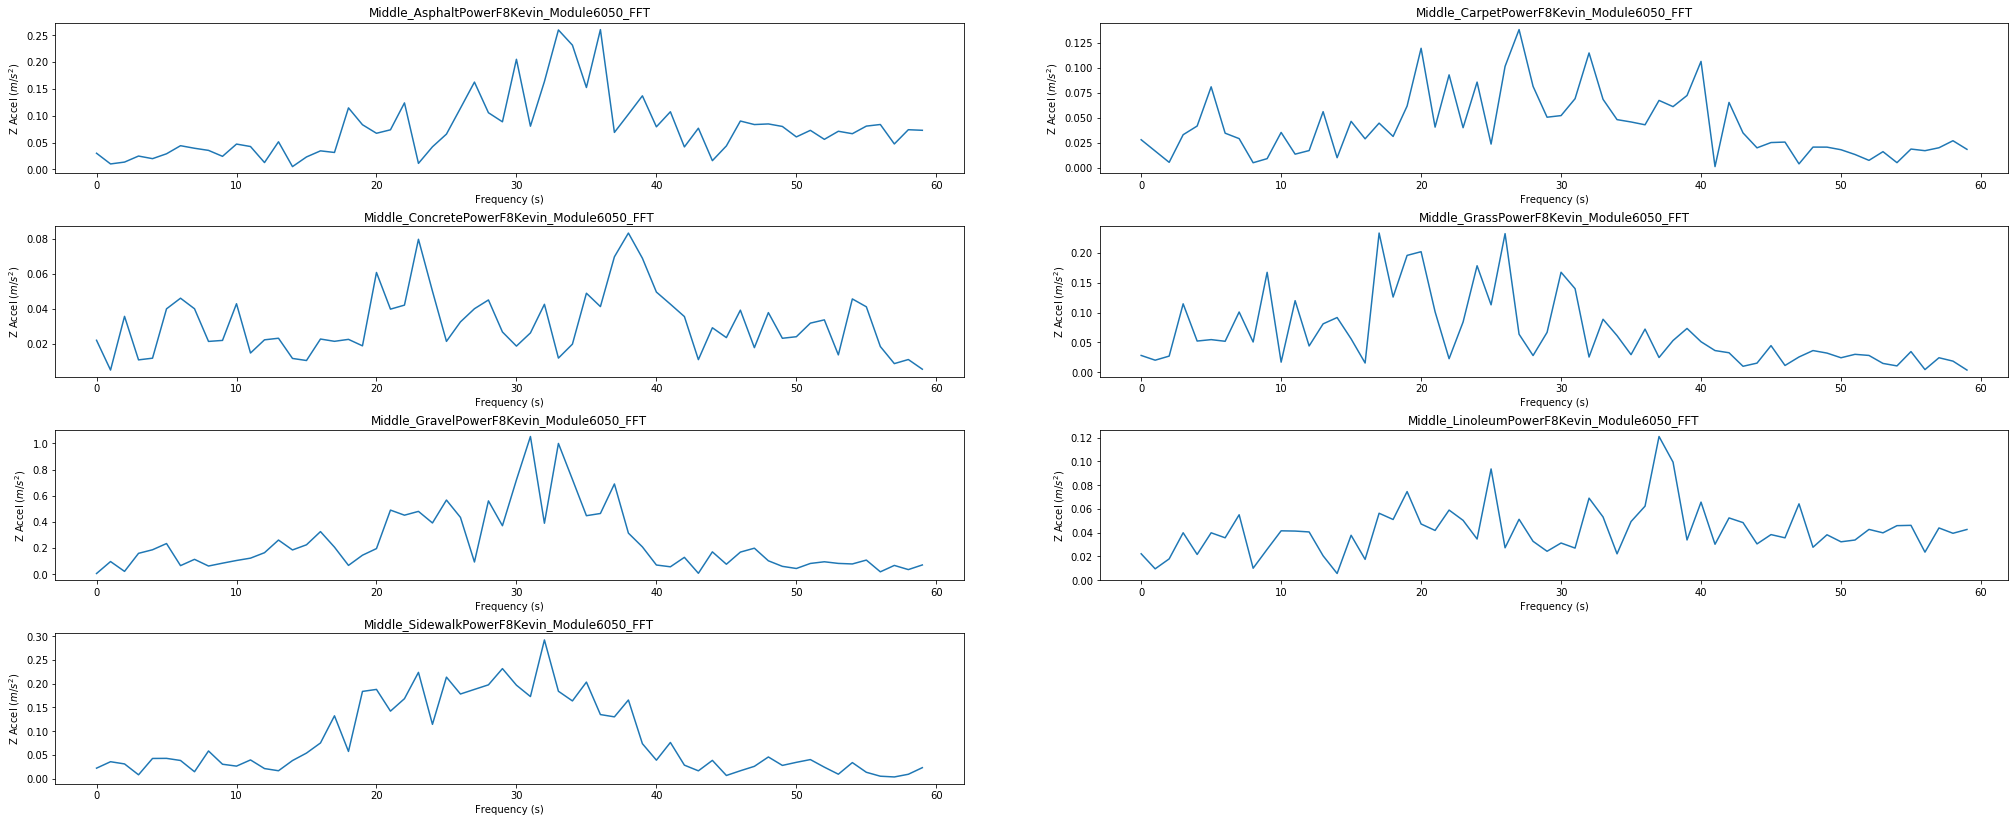

In [39]:
# Compare some FFTs
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [40]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + '_PSD': dataset_psd})
    datasets_psd_log.update({label +'_PSDLog': dataset_psd_log})

In [41]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'_PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'_PSD'][0].shape))

Num PSD'd windowed datasets: 86
Num of PSD'd windows in first dataset: 122
Shape of PSD'd individual window: (60, 7)


<Figure size 432x288 with 0 Axes>

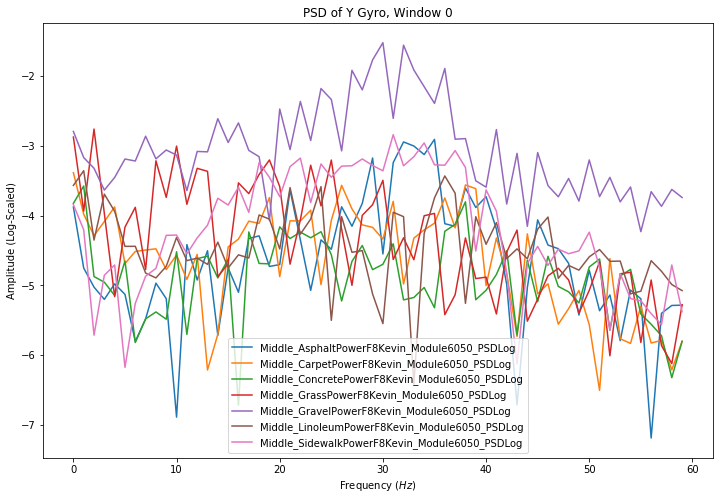

In [42]:
# Compare some Log PSDs
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=4, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

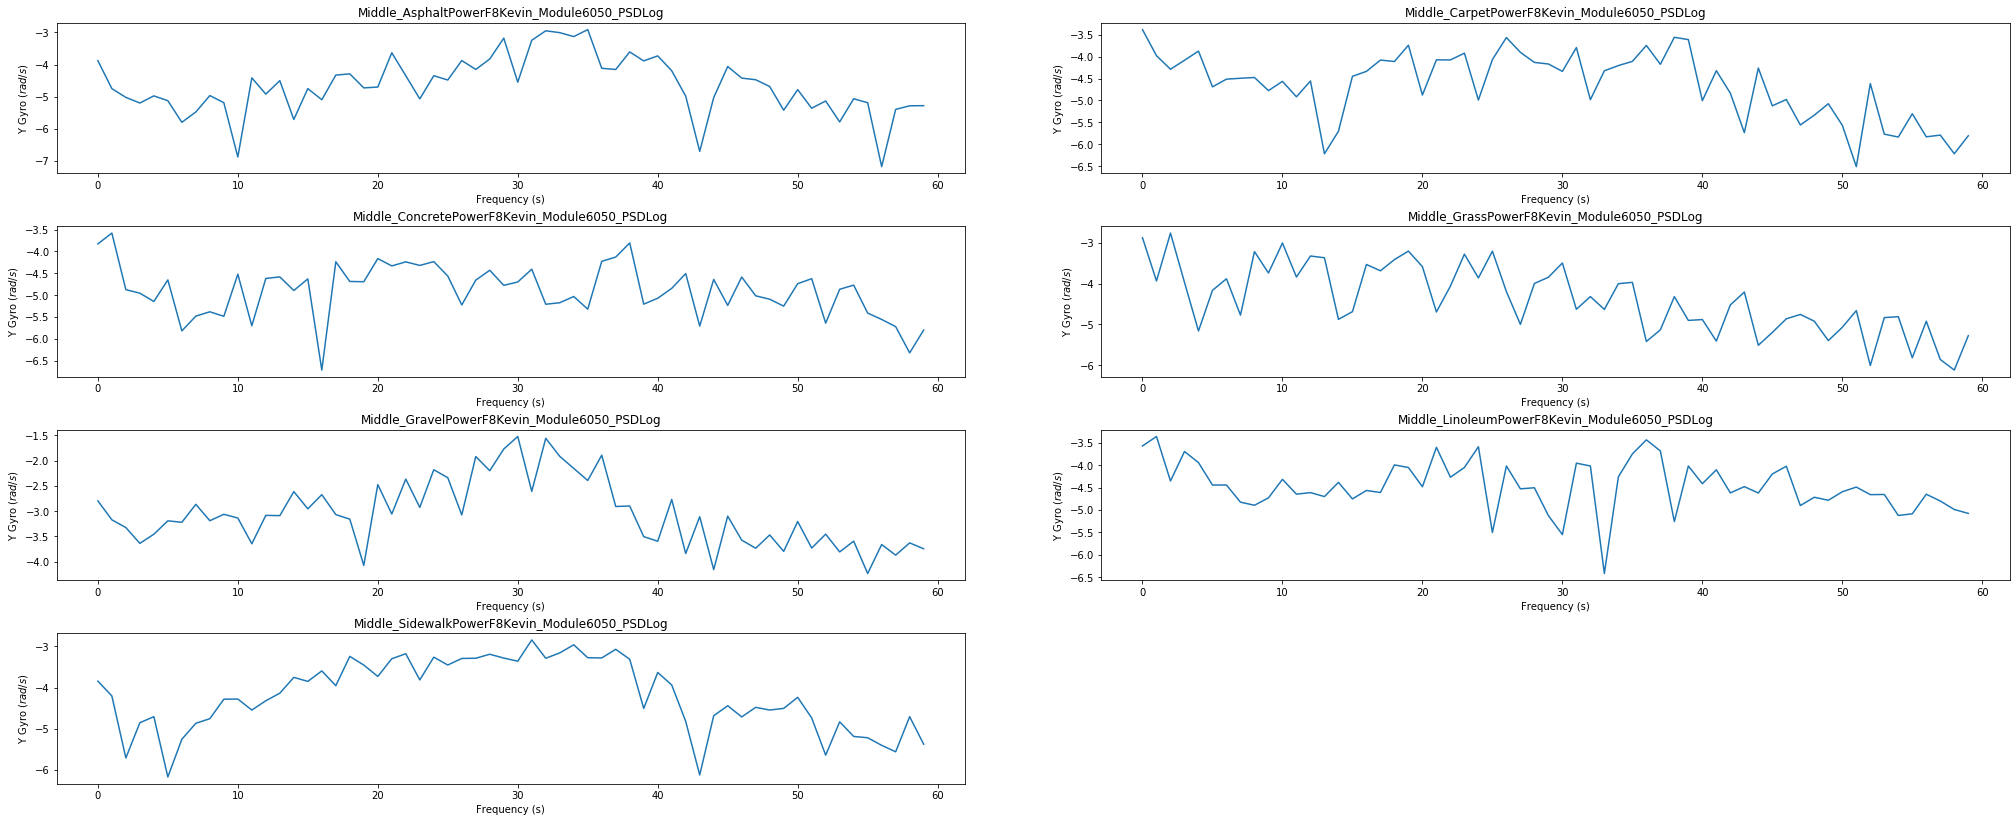

In [43]:
# Compare some Log PSDs
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Y Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [44]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific plot parameters for different transforms
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}'.format(win_num))
    
    plt.show()

<Figure size 432x288 with 0 Axes>

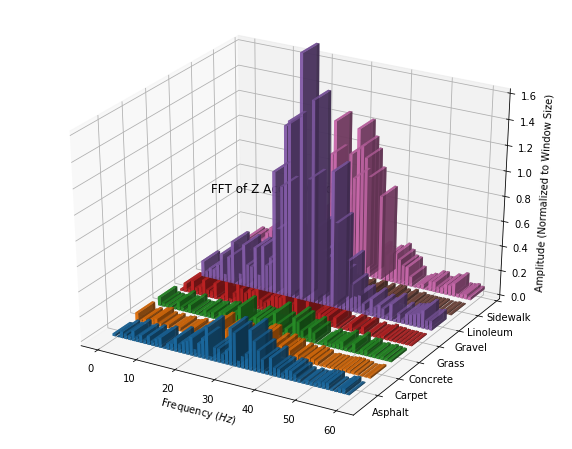

In [45]:
# Compare some FFTs in 3D
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

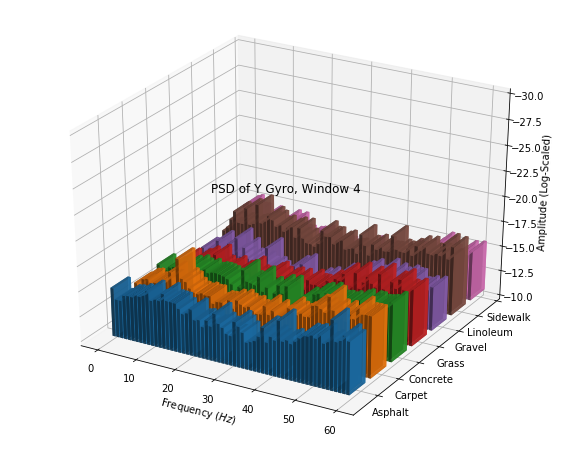

In [46]:
# Compare some PSDs in 3D
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_transforms_3d(psds_to_plot, win_num=4, dirn=4, transform_name='PSD')

### Part (d) - Spectograms

In [47]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

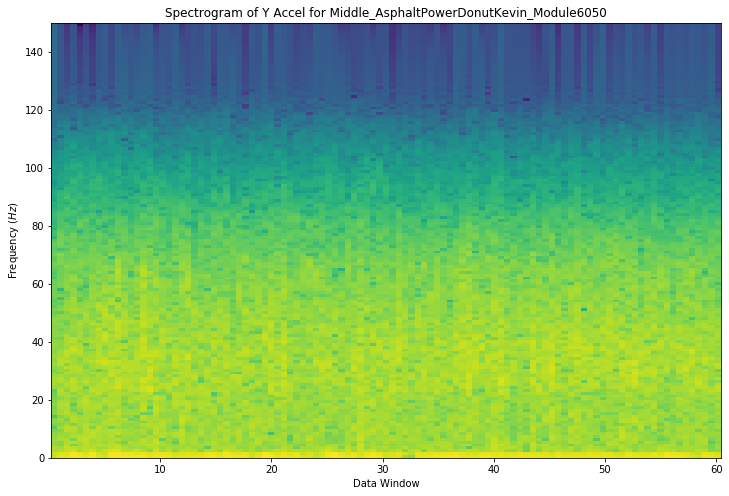

In [48]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

Extract relevant features (e.g. Mean, Min, Skew, ...) from each data window

In [49]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Find locations where array > 0, put -1 and 1 for each rising/falling point from 0,
    # divide by total datapoints in window
    return len(np.nonzero(np.diff(array > 0.0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [50]:
'''Extract given features from column of each dataset
   Converts a dictionary of datasets to a nested dictionary where each dataset has its own dictionary
   of axes/directions'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window        
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('_PSD', ''): directions})
    
    return datasets_feat

In [51]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
    
    # Set limits if they've been given
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [52]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std': np.std,  'Norm': l2norm, 'AC': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'RMS': rms, 'ZCR': zcr, 
                 'Skew': stats.skew, 'EK': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [53]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 86
Num directions: 6
Shape of first dataset first direction: (122, 10)


<Figure size 432x288 with 0 Axes>

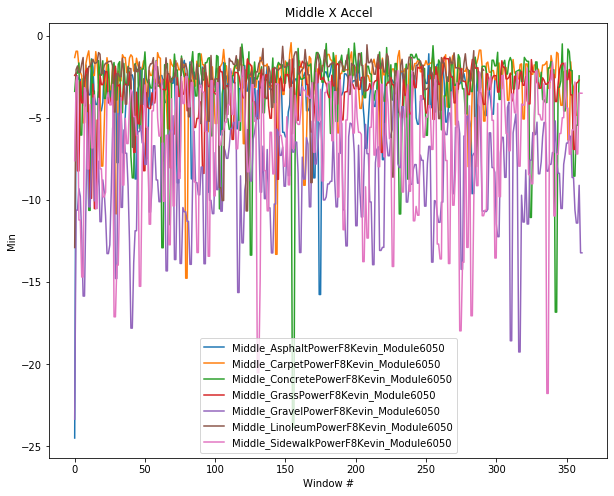

In [54]:
# Plot some time feature data
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [55]:
# Frequency domain feature functions and names
freq_features = {'MSF': msf, 'RMSF': rmsf, 'FC': fc, 'VF': vf, 'RVF': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [56]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 86
Num directions: 6
Shape of one direction: (122, 5)


<Figure size 432x288 with 0 Axes>

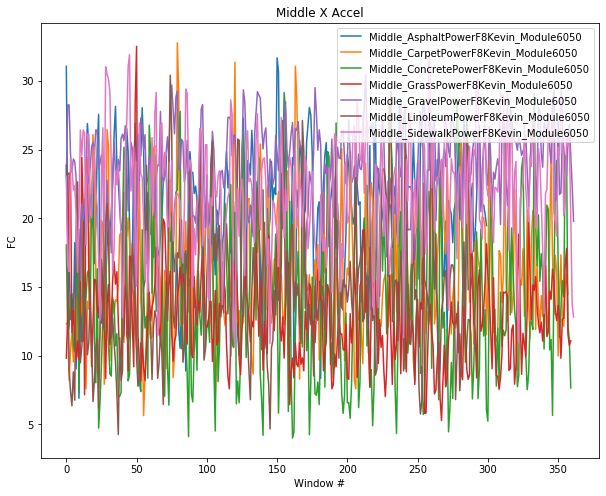

In [57]:
# Plot some frequency feature data
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'F8' in label and 'Kevin' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='FC', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Columning, Combination, and Standardization of Datasets

In [58]:
# Convert transform data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

### Part (a) - Columning Data

Combine IMU data from each direction into single dataframes with columns for each feature in each direction

In [59]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

#### Part (i) - Extracted Featured Data

In [60]:
'''Combined directions (axes) of a featured dataset'''
def combine_extracted_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [61]:
# Take time feature data and combine axes columns
datasets_feat_time_columned = combine_extracted_columns(datasets_feat_time)

# Confirm formatting
datasets_feat_time_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,EK X Accel Middle,...,Mean Z Gyro Middle,Std Z Gyro Middle,Norm Z Gyro Middle,AC Z Gyro Middle,Max Z Gyro Middle,Min Z Gyro Middle,RMS Z Gyro Middle,ZCR Z Gyro Middle,Skew Z Gyro Middle,EK Z Gyro Middle
0,0.862495,1.844312,35.264931,1243.615373,10.330600,-23.988526,2.036022,0.063333,-7.529461,110.845631,...,0.483653,0.251853,9.444843,89.205067,0.892146,0.044547,0.545298,0.0,-0.110063,-1.279266
1,0.707485,1.012651,21.396240,457.799066,3.991531,-2.112190,1.235312,0.113333,0.105735,0.377111,...,0.758320,0.102093,13.252989,175.641714,0.969991,0.464024,0.765162,0.0,-1.209289,0.930456
2,0.594825,1.531267,28.453093,809.578485,7.007151,-3.742925,1.642740,0.150000,0.296430,1.491256,...,0.691233,0.162927,12.300587,151.304434,0.969991,0.286606,0.710175,0.0,-0.995663,-0.179920
3,0.607243,2.012887,36.416172,1326.137577,7.361209,-4.190886,2.102489,0.143333,0.530245,0.820840,...,0.802940,0.271171,14.679019,215.473610,1.286645,0.286606,0.847494,0.0,-0.164186,-1.146706
4,0.518910,1.814564,32.689031,1068.572721,7.361209,-4.190886,1.887302,0.160000,0.652680,1.370579,...,0.988057,0.116605,17.232415,296.956113,1.286645,0.708260,0.994914,0.0,0.136549,-0.371752


In [62]:
# Take frequency feature data and axes columns
datasets_feat_freq_columned = combine_extracted_columns(datasets_feat_freq)

# Confirm formatting
datasets_feat_freq_columned[dataset_labels[0]].head()

,MSF X Accel Middle,RMSF X Accel Middle,FC X Accel Middle,VF X Accel Middle,RVF X Accel Middle,MSF Y Accel Middle,RMSF Y Accel Middle,FC Y Accel Middle,VF Y Accel Middle,RVF Y Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
0,2.006067,1.416357,33.854652,-1144.131377,1.416357,0.053803,0.231955,13.154383,-172.983985,0.231955,...,0.007286,0.085358,27.994992,-783.712296,0.085358,0.000775,0.027830,1.148884,-1.319159,0.027830
1,0.638107,0.798816,21.560727,-464.226862,0.798816,0.643324,0.802075,21.433887,-458.768169,0.802075,...,0.062411,0.249823,30.219005,-913.125866,0.249823,0.004203,0.064833,3.847061,-14.795674,0.064833
2,1.489176,1.220318,22.233822,-492.853669,1.220318,0.675874,0.822115,21.912850,-479.497135,0.822115,...,0.121214,0.348158,31.588110,-997.687490,0.348158,0.000875,0.029585,1.174124,-1.377693,0.029585
3,2.136829,1.461790,21.044712,-440.743093,1.461790,0.577708,0.760071,15.866557,-251.169930,0.760071,...,0.077744,0.278827,30.633712,-938.346583,0.278827,0.000230,0.015160,0.655851,-0.429911,0.015160
4,1.787488,1.336970,20.764134,-429.361785,1.336970,0.718282,0.847515,21.462562,-459.923281,0.847515,...,0.055460,0.235500,28.879725,-833.983077,0.235500,0.004316,0.065700,4.830206,-23.326572,0.065700


#### Part (ii) - Transformed Data

In [63]:
'''Combined direction (axes) columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        # Get frequency bins from frequency column of first window
        freq_bins = dataset[0]['Frequency'].tolist()
        
        # Get more parameter for current label
        data_cols = get_columns(label)[:get_n_data_col(label)]
        trans = get_transform(label)
        place = get_placement(label)
        
        # Combine parameters to form columns for new combined DataFrame
        new_cols = [trans + ' {} Hz '.format(round(f_bin)) + d_col + ' ' + place for d_col in data_cols for f_bin in freq_bins]
        
        # Convert windowed arrays into a single array with each window as a row
        new_data = []
        
        for window in dataset:
            new_row = []
            for d_col in data_cols:
                new_row.extend(window[d_col].tolist())
            new_data.append(new_row)
            
        # Create new DataFrame
        combined_df = pd.DataFrame(data=new_data, columns=new_cols)
        combined_datasets.update({label: combined_df})

    return combined_datasets

In [64]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

# Confirm FFT formatting
datasets_fft_columned[dataset_labels[0] + '_FFT'].head()

,FFT 0 Hz X Accel Middle,FFT 1 Hz X Accel Middle,FFT 2 Hz X Accel Middle,FFT 3 Hz X Accel Middle,FFT 4 Hz X Accel Middle,FFT 5 Hz X Accel Middle,FFT 6 Hz X Accel Middle,FFT 7 Hz X Accel Middle,FFT 8 Hz X Accel Middle,FFT 9 Hz X Accel Middle,...,FFT 50 Hz Z Gyro Middle,FFT 51 Hz Z Gyro Middle,FFT 52 Hz Z Gyro Middle,FFT 53 Hz Z Gyro Middle,FFT 54 Hz Z Gyro Middle,FFT 55 Hz Z Gyro Middle,FFT 56 Hz Z Gyro Middle,FFT 57 Hz Z Gyro Middle,FFT 58 Hz Z Gyro Middle,FFT 59 Hz Z Gyro Middle
0,0.862495,0.318967,0.215261,0.131843,0.083893,0.026973,0.097153,0.101025,0.094040,0.046772,...,0.002798,0.003243,0.002408,0.001877,0.001349,0.002506,0.002033,0.002185,0.001951,0.001647
1,0.707485,0.187281,0.203979,0.147563,0.099127,0.130043,0.078476,0.134599,0.095598,0.069418,...,0.000691,0.001584,0.000322,0.002706,0.000340,0.000540,0.000981,0.001612,0.001141,0.001205
2,0.594825,0.196880,0.297157,0.266984,0.084236,0.187376,0.215144,0.174779,0.102317,0.090699,...,0.001404,0.002108,0.000917,0.001884,0.000642,0.001030,0.000449,0.000151,0.000558,0.000509
3,0.607243,0.453146,0.042915,0.327594,0.320018,0.070115,0.278496,0.282016,0.156744,0.158840,...,0.002405,0.001072,0.001741,0.000689,0.002231,0.000643,0.001526,0.001631,0.001178,0.000477
4,0.518910,0.516102,0.138371,0.142538,0.140774,0.251654,0.107827,0.121234,0.227172,0.264174,...,0.001121,0.002360,0.001183,0.001901,0.000333,0.001444,0.001519,0.002035,0.002062,0.001071


In [65]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

# Check PSD formatting
datasets_psd_log_columned[dataset_labels[0] + '_PSDLog'].head()

,PSDLog 0 Hz X Accel Middle,PSDLog 1 Hz X Accel Middle,PSDLog 2 Hz X Accel Middle,PSDLog 3 Hz X Accel Middle,PSDLog 4 Hz X Accel Middle,PSDLog 5 Hz X Accel Middle,PSDLog 6 Hz X Accel Middle,PSDLog 7 Hz X Accel Middle,PSDLog 8 Hz X Accel Middle,PSDLog 9 Hz X Accel Middle,...,PSDLog 50 Hz Z Gyro Middle,PSDLog 51 Hz Z Gyro Middle,PSDLog 52 Hz Z Gyro Middle,PSDLog 53 Hz Z Gyro Middle,PSDLog 54 Hz Z Gyro Middle,PSDLog 55 Hz Z Gyro Middle,PSDLog 56 Hz Z Gyro Middle,PSDLog 57 Hz Z Gyro Middle,PSDLog 58 Hz Z Gyro Middle,PSDLog 59 Hz Z Gyro Middle
0,-0.691478,-1.033040,-1.458853,-1.851520,-2.837103,-1.724054,-1.690110,-1.752346,-2.359003,-2.373500,...,-4.677016,-4.935684,-5.151967,-5.438887,-4.901133,-5.082848,-5.020000,-5.118434,-5.265530,-4.954071
1,-1.153984,-1.079797,-1.361016,-1.706582,-1.470796,-1.909491,-1.440887,-1.738075,-2.016025,-2.522290,...,-5.299676,-6.684398,-4.834359,-6.634908,-6.233942,-5.715912,-5.284451,-5.584152,-5.536725,-5.549842
2,-1.110565,-0.752999,-0.846000,-1.847977,-1.153540,-1.033513,-1.213991,-1.679070,-1.783760,-1.013761,...,-5.051275,-5.773853,-5.148732,-6.084467,-5.673647,-6.395101,-7.341896,-6.205604,-6.285122,-5.909537
3,-0.386494,-2.433760,-0.668298,-0.688620,-2.007354,-0.809333,-0.798421,-1.308590,-1.297051,-0.893118,...,-5.638722,-5.217154,-6.022589,-5.001899,-6.082499,-5.331847,-5.273924,-5.556794,-6.342547,-5.683137
4,-0.273498,-1.416879,-1.391107,-1.401928,-0.897361,-1.633517,-1.531721,-0.986261,-0.855189,-1.905261,...,-4.953305,-5.553249,-5.140979,-6.654250,-5.379717,-5.335640,-5.081985,-5.070421,-5.639380,-5.648266


### Part (b) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [66]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [67]:
# Add labels to each of the feature vector types
datasets_feat_time_columned = insert_labels(datasets_feat_time_columned)
datasets_feat_freq_columned = insert_labels(datasets_feat_freq_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [68]:
# Check labelled data
datasets_feat_time_columned[dataset_labels[0]].head()

,Label,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,...,Mean Z Gyro Middle,Std Z Gyro Middle,Norm Z Gyro Middle,AC Z Gyro Middle,Max Z Gyro Middle,Min Z Gyro Middle,RMS Z Gyro Middle,ZCR Z Gyro Middle,Skew Z Gyro Middle,EK Z Gyro Middle
0,3,0.862495,1.844312,35.264931,1243.615373,10.330600,-23.988526,2.036022,0.063333,-7.529461,...,0.483653,0.251853,9.444843,89.205067,0.892146,0.044547,0.545298,0.0,-0.110063,-1.279266
1,3,0.707485,1.012651,21.396240,457.799066,3.991531,-2.112190,1.235312,0.113333,0.105735,...,0.758320,0.102093,13.252989,175.641714,0.969991,0.464024,0.765162,0.0,-1.209289,0.930456
2,3,0.594825,1.531267,28.453093,809.578485,7.007151,-3.742925,1.642740,0.150000,0.296430,...,0.691233,0.162927,12.300587,151.304434,0.969991,0.286606,0.710175,0.0,-0.995663,-0.179920
3,3,0.607243,2.012887,36.416172,1326.137577,7.361209,-4.190886,2.102489,0.143333,0.530245,...,0.802940,0.271171,14.679019,215.473610,1.286645,0.286606,0.847494,0.0,-0.164186,-1.146706
4,3,0.518910,1.814564,32.689031,1068.572721,7.361209,-4.190886,1.887302,0.160000,0.652680,...,0.988057,0.116605,17.232415,296.956113,1.286645,0.708260,0.994914,0.0,0.136549,-0.371752


### Part (c) - Combining Datasets

Convert data from each dataset into rows of a single dataframe

In [69]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [70]:
'''Separate data according to placement, then combine data for each placement and return
   as a dictionary of placements'''
def separate_and_combine(datasets_columned):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # TODO: Figure out where NaNs come from
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='rows')})
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [71]:
# For each feature vector, combine datasets in two single dataframes
time_feats_unnorm = separate_and_combine(datasets_feat_time_columned)
freq_feats_unnorm = separate_and_combine(datasets_feat_freq_columned)                                      
ffts_unnorm = separate_and_combine(datasets_fft_columned)
psd_logs_unnorm = separate_and_combine(datasets_psd_log_columned)

In [73]:
# Check unnormalized data
time_feats_unnorm['Middle'].tail()

,Label,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,...,Mean Z Gyro Middle,Std Z Gyro Middle,Norm Z Gyro Middle,AC Z Gyro Middle,Max Z Gyro Middle,Min Z Gyro Middle,RMS Z Gyro Middle,ZCR Z Gyro Middle,Skew Z Gyro Middle,EK Z Gyro Middle
17537,4,0.010678,2.874051,49.780374,2478.085616,8.812500,-11.393264,2.874071,0.213333,-0.292792,...,0.062775,0.110910,2.207381,4.872532,0.422162,-0.272812,0.127443,0.093333,-0.144535,0.318365
17538,4,-0.344940,3.050623,53.175050,2827.585940,12.008746,-11.393264,3.070063,0.230000,0.617161,...,0.064154,0.132843,2.555169,6.528890,0.708696,-0.272812,0.147523,0.083333,0.665955,2.571881
17539,4,-0.238116,2.529345,44.003248,1936.285805,12.008746,-5.599471,2.540529,0.186667,1.722456,...,-0.109990,0.165286,3.438782,11.825220,0.708696,-0.361768,0.198538,0.063333,1.151251,2.793199
17540,4,-1.738191,2.018075,46.132207,2128.180486,4.567254,-8.093194,2.663444,0.080000,0.063857,...,-0.094180,0.168439,3.342527,11.172489,0.282390,-0.361768,0.192981,0.023333,0.241387,-1.205931
17541,4,-2.032302,1.759899,46.564454,2168.248339,2.861537,-8.093194,2.688400,0.033333,-0.246579,...,0.021377,0.093840,1.666994,2.778868,0.282390,-0.338531,0.096244,0.030000,-0.276710,1.618149


### Part (d) - Standardization (aka Normalization)

Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [74]:
'''Normalize combined datasets
   Returns normalized combined datasets, and the parameters (mean, standard dev) used for normalization
   of each feature vector column'''
# TODO: Look into standard real time normalization
# TODO: Compare mean/std dev of features for different subjects
def normalize_datasets(placements):
    # Object to keep track of scaling parameters
    from sklearn.preprocessing import StandardScaler
    
    placements_norm = {}
    placements_norm_parameters = {}
    
    # Go through combined data
    for placement_name, placement_combined_data in placements.items():
        combined_data = placement_combined_data.copy()
        
        # Pop labels and add back in later, also keep track of columns
        df_labels = combined_data.pop('Label').astype('int32')
        df_cols = combined_data.columns
        scaler = StandardScaler().fit(combined_data)
        
        # Keep track of mean and std deviation (scale_) of scaler for each column as a dictionary
        placement_columns = {}
        for i, df_col in enumerate(df_cols):
            placement_columns.update({df_col: {'Mean': scaler.mean_[i], 'Scale': scaler.scale_[i]}})
            
        placements_norm_parameters.update({placement_name: placement_columns})
        
        # Normalize each combined feature and update placement dictionary
        # Scaler converts to numpy so convert back to DataFrame
        norm_combined_data = scaler.transform(combined_data)
        norm_df = pd.DataFrame(data=norm_combined_data, columns=df_cols)
        norm_df = norm_df.dropna()
        norm_df.insert(0, 'Label', df_labels)
        placements_norm.update({placement_name: norm_df})
        
    return placements_norm, placements_norm_parameters

In [78]:
time_feats, time_feat_params = normalize_datasets(time_feats_unnorm)
freq_feats, freq_feat_params = normalize_datasets(freq_feats_unnorm)
ffts, fft_params = normalize_datasets(ffts_unnorm)
psd_logs, psd_log_params = normalize_datasets(psd_logs_unnorm)

In [80]:
# Check combined and normalized extracted time feature vectors
print('Time Feat Param Dictionary: {}'.format(time_feat_params['Middle']['Mean X Accel Middle']))
time_feats['Middle'].tail()

Time Feat Param Dictionary: {'Mean': 0.08391007209008465, 'Scale': 0.4581178781842851}


,Label,Mean X Accel Middle,Std X Accel Middle,Norm X Accel Middle,AC X Accel Middle,Max X Accel Middle,Min X Accel Middle,RMS X Accel Middle,ZCR X Accel Middle,Skew X Accel Middle,...,Mean Z Gyro Middle,Std Z Gyro Middle,Norm Z Gyro Middle,AC Z Gyro Middle,Max Z Gyro Middle,Min Z Gyro Middle,RMS Z Gyro Middle,ZCR Z Gyro Middle,Skew Z Gyro Middle,EK Z Gyro Middle
17537,4,-0.159855,1.739074,1.656755,1.268979,1.182622,-2.025991,1.656300,1.835935,-0.448861,...,0.075965,-0.966083,-1.623041,-1.073354,-0.088910,0.259994,-1.623513,5.398095,-0.228316,1.089372
17538,4,-0.936113,1.946017,1.887787,1.543571,2.143694,-2.025991,1.887335,2.195746,0.582942,...,0.077285,-0.855231,-1.584576,-1.068442,0.184396,0.259994,-1.585044,4.781747,1.118012,3.600556
17539,4,-0.702932,1.335077,1.263580,0.843303,2.143694,-0.326587,1.263120,1.260236,1.836245,...,-0.089353,-0.691254,-1.486850,-1.052733,0.184396,0.176397,-1.487306,3.549051,1.924154,3.847180
17540,4,-3.977362,0.735867,1.408471,0.994069,-0.093871,-1.058032,1.408013,-1.042557,-0.044453,...,-0.074224,-0.675319,-1.497495,-1.054669,-0.222230,0.176397,-1.497953,1.083659,0.412749,-0.609213
17541,4,-4.619362,0.433282,1.437888,1.025549,-0.606759,-1.058032,1.437431,-2.050030,-0.396459,...,0.036352,-1.052361,-1.682807,-1.079564,-0.222230,0.198234,-1.683286,1.494558,-0.447877,2.537773


In [81]:
# Check combined and normalized extracted time feature vectors
print('Freq Feat Param Dictionary: {}'.format(freq_feat_params['Middle']['FC X Accel Middle']))
freq_feats['Middle'].tail()

Freq Feat Param Dictionary: {'Mean': 17.279460881575023, 'Scale': 6.1847849359474125}


,Label,MSF X Accel Middle,RMSF X Accel Middle,FC X Accel Middle,VF X Accel Middle,RVF X Accel Middle,MSF Y Accel Middle,RMSF Y Accel Middle,FC Y Accel Middle,VF Y Accel Middle,...,MSF Y Gyro Middle,RMSF Y Gyro Middle,FC Y Gyro Middle,VF Y Gyro Middle,RVF Y Gyro Middle,MSF Z Gyro Middle,RMSF Z Gyro Middle,FC Z Gyro Middle,VF Z Gyro Middle,RVF Z Gyro Middle
17537,4,0.627587,1.412184,1.292853,-1.379749,1.412184,3.372849,3.319151,2.456581,-3.373132,...,0.223653,0.986098,1.368695,-1.753567,0.986098,-0.077635,0.216004,8.416601,-10.116667,0.216004
17538,4,0.489874,1.229542,1.128504,-1.150770,1.229542,3.992184,3.656053,2.381288,-3.218503,...,0.654897,1.649602,1.118324,-1.342177,1.649602,0.089699,0.420243,8.163369,-9.566021,0.420243
17539,4,0.215701,0.813043,0.879996,-0.824796,0.813043,1.185472,1.817119,1.906799,-2.390157,...,0.330365,1.171983,1.086557,-1.292503,1.171983,-0.578080,-0.670019,2.291943,-1.021622,-0.670019
17540,4,-0.145026,0.043540,-0.917600,0.932260,0.043540,1.204660,1.833838,0.814749,-0.725826,...,-0.137174,0.088392,0.699786,-0.711818,0.088392,-0.369263,-0.219232,0.598344,-0.061046,-0.219232
17541,4,-0.251395,-0.327722,-1.269306,1.140921,-0.327722,1.342780,1.951329,0.680460,-0.551393,...,-0.154841,0.017156,0.557475,-0.512417,0.017156,-0.429600,-0.330455,2.518925,-1.201498,-0.330455


#### Note: More rows of exracted feature data are lost than transform features

In [82]:
# Check combined and normalized extracted time feature vectors
print('FFT Parameter Dictionary: {}'.format(fft_params['Middle']['FFT 0 Hz X Accel Middle']))
ffts['Middle'].tail()

FFT Parameter Dictionary: {'Mean': 0.34882578803310915, 'Scale': 0.30749806674062774}


,Label,FFT 0 Hz X Accel Middle,FFT 1 Hz X Accel Middle,FFT 2 Hz X Accel Middle,FFT 3 Hz X Accel Middle,FFT 4 Hz X Accel Middle,FFT 5 Hz X Accel Middle,FFT 6 Hz X Accel Middle,FFT 7 Hz X Accel Middle,FFT 8 Hz X Accel Middle,...,FFT 50 Hz Z Gyro Middle,FFT 51 Hz Z Gyro Middle,FFT 52 Hz Z Gyro Middle,FFT 53 Hz Z Gyro Middle,FFT 54 Hz Z Gyro Middle,FFT 55 Hz Z Gyro Middle,FFT 56 Hz Z Gyro Middle,FFT 57 Hz Z Gyro Middle,FFT 58 Hz Z Gyro Middle,FFT 59 Hz Z Gyro Middle
17537,4,-1.099676,2.402638,0.259076,1.708055,1.221065,0.068728,-0.387685,0.154421,1.045134,...,0.691602,1.705582,1.794153,4.372303,1.536949,2.407890,-0.060941,1.601178,0.145632,-0.202104
17538,4,-0.012637,2.425236,0.085653,1.523361,0.874856,-0.477689,1.538074,0.505293,0.546959,...,2.224110,2.889204,4.019268,3.329421,3.389431,-0.204491,2.065445,1.813158,0.074666,0.601798
17539,4,-0.360035,0.835723,1.364377,0.092155,-0.034875,0.971918,1.909489,1.545684,2.856382,...,1.047957,1.331355,3.128078,2.063500,0.937122,1.505856,-0.488460,0.895243,0.621698,-0.239831
17540,4,4.518288,2.452624,-0.936979,1.664216,0.361817,2.620376,1.189138,0.745566,2.772913,...,0.256460,-0.745505,-0.790154,-0.355326,-0.285118,-0.460069,-0.849201,-0.563721,-0.481459,0.024511
17541,4,5.474754,2.309136,1.087936,1.106388,0.771499,0.856187,1.889029,0.472545,0.201580,...,-0.959330,-0.440930,-0.841109,-0.882162,-0.909143,-0.397539,-0.791306,-0.807224,-0.767822,-0.087563


In [83]:
# Check combined and normalized extracted time feature vectors
print('PSD Log Parameter Dictionary: {}'.format(psd_log_params['Middle']['PSDLog 0 Hz X Accel Middle']))
psd_logs['Middle'].tail()

PSD Log Parameter Dictionary: {'Mean': -0.9929247471022896, 'Scale': 0.6498121291709706}


,Label,PSDLog 0 Hz X Accel Middle,PSDLog 1 Hz X Accel Middle,PSDLog 2 Hz X Accel Middle,PSDLog 3 Hz X Accel Middle,PSDLog 4 Hz X Accel Middle,PSDLog 5 Hz X Accel Middle,PSDLog 6 Hz X Accel Middle,PSDLog 7 Hz X Accel Middle,PSDLog 8 Hz X Accel Middle,...,PSDLog 50 Hz Z Gyro Middle,PSDLog 51 Hz Z Gyro Middle,PSDLog 52 Hz Z Gyro Middle,PSDLog 53 Hz Z Gyro Middle,PSDLog 54 Hz Z Gyro Middle,PSDLog 55 Hz Z Gyro Middle,PSDLog 56 Hz Z Gyro Middle,PSDLog 57 Hz Z Gyro Middle,PSDLog 58 Hz Z Gyro Middle,PSDLog 59 Hz Z Gyro Middle
17537,4,1.483486,0.529275,1.380523,1.175504,0.435587,-0.067526,0.487544,1.043764,1.233202,...,1.302332,1.338782,2.009953,1.247205,1.538105,0.331615,1.276494,0.506807,0.203000,0.692244
17538,4,1.490879,0.393445,1.302140,0.996015,-0.203597,1.296814,0.743659,0.765005,1.502560,...,1.664489,1.931623,1.787407,1.794972,0.188541,1.422163,1.353407,0.450943,0.804666,0.047212
17539,4,0.834591,1.164309,0.430221,0.330316,1.050951,1.443254,1.282626,1.712435,1.916959,...,1.156753,1.731421,1.436374,0.986127,1.234125,-0.147469,0.970769,0.819796,0.163831,-0.043166
17540,4,1.499785,-0.984100,1.362360,0.667104,1.700671,1.140400,0.891684,1.688721,-0.317584,...,-0.599643,-0.702783,0.014500,0.099751,-0.116324,-0.848964,-0.271684,-0.137072,0.411160,0.151068
17541,4,1.452453,1.032468,1.104614,0.936696,0.988105,1.435643,0.721969,0.523512,1.091393,...,-0.091215,-0.829560,-0.953896,-1.050734,-0.033311,-0.699979,-0.763954,-0.651859,0.313490,0.021053


## Part 7 - Exporting Data

### Part (a) - Convert to .csv Files
Convert feature vectors to .csv so we can use them in separate notebook

In [84]:
vector_dict = {'TimeFeats': time_feats, 'FreqFeats': freq_feats, 'FFTs': ffts, 'PSDLogs': psd_logs}

# Save each vector and each placement to .csv file
for vector_name, vector_data in vector_dict.items():
    for placement_name, placement_df in vector_data.items():
        placement_df.to_csv('processed_data/' + placement_name + '_' + vector_name + '_' + 'All_Power.csv',
                            index=False)
        
# TODO: Use a pickle instead?

### Part (b) - Pickle Normalization Parameter Dictionaries

In [85]:
import pickle

relative_path = '/home/caris/Wheelchair-Terrain-Classification/dicts/'
vector_param_dict = {'TimeFeats': time_feat_params, 'FreqFeats': freq_feat_params,
                     'FFTs': fft_params, 'PSDLogs': psd_log_params}

# Pickle each feature vector
for vector_name, vector_param_dict in vector_param_dict.items():
    norm_param_dict_filename = relative_path + vector_name + '_Norm_Param_Dictionary_Power.pkl'
    outfile = open(norm_param_dict_filename, 'wb')
    pickle.dump(vector_param_dict, outfile)
    outfile.close()

#### To standardize data using already computed normalization parameters:

`for each column of feature vector:
    for each data point in column:
        norm_value = (value - mean) / standard_deviation` 

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right